In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from signalCreationRoutines import *
import time
from burstyRoutines import *
import numpy.testing as npt

# Theory

We seek to find the FFT of a bursty signal that begins at times $x(t_0), x(t_1) ...$ and lasts for $t_L$ seconds.
The most obvious way to perform this is to capture all the bursts in one window and perform a single FFT.
However, this can be very inefficient if the gap between each burst is very large i.e. $t_0 + t_L << t_1, t_1 + t_L << t_2 ...$. In such a scenario, zeroing out the empty space between each burst is commonplace and will result in the FFT being needlessly computed over all the '0' samples.

Instead, we would like to perform the FFT over each short burst and then combine them such that the result for a particular bin would be the same as if the FFT had been taken over all the bursts together.

To do this, consider the standard form of the FFT:

$$X(k) = \sum^{N-1}_{n} x(n) e^{-i 2 \pi k n / N}, k = 0, 1, ... N-1 $$

In practice, one would have pre-processed the bursts to at least know the samples at which each burst starts; that is, we can define the samples $n_0, n_1 ...$ as the starting samples for each burst. Similarly, we can define the length of the burst as $L$ (this can be rounded up to the nearest sample if $t_L$ sits in a subsample range.

We would now perform the FFTs over each burst in the following way:

$$X_i (k) = \sum^{L-1}_{l} x(n_i + l) e^{-i 2 \pi k l / L}, k = 0, 1, .. L-1 $$

Now, clearly the FFT resolution for the short burst is far worse i.e. the bin widths are larger due to taking a smaller window. We will get to this. For now, suppose the original (large) window length is an integer multiple of the shorter window length i.e. $N = \alpha L$.

Then, every $\alpha$'th bin in the original (large) window corresponds to a bin in the shorter window. We will use this to demonstrate the corrections required.

Consider the first pair of bins which correspond to each other: this is the integer $\alpha$ in the original (large) window and the integer $1$ in the shorter window. There is no change in the 0'th terms (which do pair up with each other) as they are simply summations over all samples, and are equivalent without any corrections.

Remembering that $N = \alpha L$, we have

$$X(\alpha) = \sum^{N-1}_{n} x(n) e^{-i 2 \pi \alpha n / N}, k = 0, 1, ... N-1 $$
$$X_i (1) = \sum^{L-1}_{l} x(n_i + l) e^{-i 2 \pi \alpha l / N}, k = 0, 1, .. L-1 $$

Consider the term at the start of the burst - the sample at $x(n_i + l)$. The contribution of this term to the original window is given by 

$$F_o = x(n_i + l) e^{-i 2 \pi \alpha (n_i + l) / N}$$

whereas the term from the short window is given by

$$F_s = x(n_i + l) e^{-i 2 \pi \alpha (l) / N}$$

which clearly shows that 

$$ F_0 = F_s e^{-i 2 \pi \alpha (n_i) / N} $$

This shows that the coefficient needed to ensure coherency between the short and long windows is the term $e^{-i 2 \pi \alpha (n_i) / N}$. It follows that the coefficients required for the other frequency pairs $(2\alpha, 2), (3\alpha, 3) ... $ are

$$ e^{-i 2 \pi 2 \alpha (n_i) / N} $$
$$ e^{-i 2 \pi 3 \alpha (n_i) / N} $$

and so on.

It should also be noted that these terms do not depend on $l$ whatsoever. Hence the following relations hold:

$$ X(\alpha) = ... + X_i(1) e^{-i 2 \pi \alpha (n_i) / N} + ... $$
$$ X(2\alpha) = ... + X_i(1) e^{-i 2 \pi 2\alpha (n_i) / N} + ... $$
$$.$$
$$.$$
$$.$$

In other words, to ensure coherency for a particular bin, we need only take the individual short window FFTs - the terms $X_i$ - with a complex exponential coefficient that depends on the starting sample. Looking at it through this vectorized format may be more intuitive from a programming perspective:

$$\begin{bmatrix}
X(0) \\
X(\alpha) \\
X(2 \alpha) \\
X(3 \alpha)\\
. \\
. \\
. \\
\end{bmatrix} = ... + \begin{bmatrix}
e^{-i 2 \pi 0\alpha (n_i) / N} \\
e^{-i 2 \pi 1\alpha (n_i) / N} \\
e^{-i 2 \pi 2\alpha (n_i) / N} \\
e^{-i 2 \pi 3\alpha (n_i) / N}\\
. \\
. \\
. \\
\end{bmatrix} \odot \begin{bmatrix}
X_i(0) \\
X_i(1) \\
X_i(2) \\
X_i(3)\\
. \\
. \\
. \\
\end{bmatrix}
 + ... $$

The $\odot$ here represents the Hadamard product (element-wise multiplication). We see that given the FFT output of the i'th burst starting at sample $n_i$ - that is, the vector $\begin{bmatrix}
X_i(0) & X_i(1) & X_i(2) & X_i(3) & ...
\end{bmatrix}^T$ - we only need to multiply in another equal length vector with coefficients that are equal to $\begin{bmatrix}
e^{-i 2 \pi 0\alpha (n_i) / N} &
e^{-i 2 \pi 1\alpha (n_i) / N} &
e^{-i 2 \pi 2\alpha (n_i) / N} &
e^{-i 2 \pi 3\alpha (n_i) / N} & ...
\end{bmatrix}^T$. Repeating this for every individual burst, one obtains coherent values for the FFT bins with respect to the original longer window.

The computational advantage for this is immediately apparent for a periodic burst. For example, if a burst has a length of 0.1s and occurs every 1s (10% occupancy in time), and the original large window captures 10 bursts, then the large window requires 10s of samples (yes, this adds the final unnecessary 0s behind the last burst, but for many bursts this will be insignificant). This results in a rough computational complexity of around $O(10 \log 10)$. On the other hand, processing 10 small FFTs will result in a complexity of around $O(10 * 0.1 \log (0.1)) = O(\log(0.1))$. This is clearly an immense decrease in complexity with the caveat that the resolution has also similarly decreased.

## Increasing the Short Window Resolution

Of course, often the resolution offered by the short burst may not be sufficient. Instead, we may wish to increase the bin resolution (decrease the bin width) by padding zeros. Assuming we pad to the periodicity of the signal, this is still likely to be a computational speed increase; in the previous example, with 0.1s bursts every 1s, this would entail taking 1s window FFTs and combining them, resulting in roughly a logarithmic reduction in complexity, $O(10 * 1 \log (1)) < O(10 \log 10)$.

Note that in this periodic burst case, this is the *maximum* complexity that would be required, as any longer window lengths would encroach into the next burst, and thus would require some custom stitching to better optimise the choice of windows - for example, the first window might use (Burst 1 + zeros + Burst 2), second window might use (Burst 3 + zeros + Burst 4) etc.

## Non-integer $\alpha$ Windows

The above scenarios considered cases where $\alpha$ is an integer. In most cases, this is either directly true (in which case nothing else needs to be done) or can be made to be true via resampling/interpolation (for cases where the bursts and/or period may span a non-integer number of samples) or considering small extensions to the original window. 

We look at an example for this last scenario. Using the same example yet again of 1s-periodic, 0.1s-length bursts, consider the simple example of just 2 bursts (original window of 2s). Instead of using short window lengths of 1s or 0.1s, let's say the bin resolution desired corresponds to 0.3s. Then, clearly

$$ 2 \neq \alpha (0.3) $$

In fact, all this indicates is that some of the bins produced by the FFTs of the 0.3s windows do not correspond to any bins produced by the original 2s window. However, **this does not mean that the above methods are incorrect**; all that is required is to actually calculate these bins manually, or to pad the original window to some integer multiple length of the shorter windows (in this case, that would be $2.1s = 7 (0.3s)$).

# Generation of Coefficient Vectors (IPP)

The complexity analysis highly depends on the efficiency of the generation of the coefficient vector. This is likely to be negligible however, from experience. It should be noted that the coefficient vector is effectively a tone and hence can be generated efficiently in IPP using ippsTone. Rearranging the terms in the phase, we have

$$
\begin{bmatrix}
e^{-i 2 \pi (\alpha n_i / N) 0} \\
e^{-i 2 \pi (\alpha n_i / N) 1} \\
e^{-i 2 \pi (\alpha n_i / N) 2} \\
e^{-i 2 \pi (\alpha n_i / N) 3}\\
. \\
. \\
. \\
e^{-i 2 \pi u_i n'} \\
.\\
.\\
.\\
\end{bmatrix}, n' = 0, 1, 2, 3, ... L-1
$$

and

$$ u_i = \alpha n_i / N $$

which is the 'relative frequency' for the i'th burst. Note that we must now treat the original time index $n_i$ as part of the 'frequency' and the original frequency index $0, 1, 2, 3..$ as part of the 'time'.




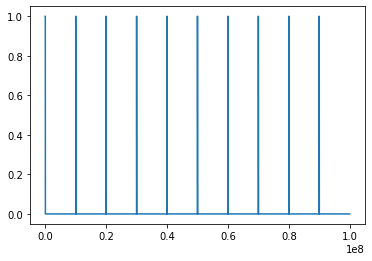

In [2]:
# create a signal
fs = 10000000
reps = 10
syms, bits = randPSKsyms(fs*reps, 4)

# zero out periodically to create some 'bursts'
burstLength = 1000
for i in range(reps):
    syms[i*fs + burstLength : (i+1) * fs] = 0
    
plt.figure()
plt.plot(np.abs(syms))

Took 5.311333 s for long fft.
Took 6.885704 s for bursty fft.


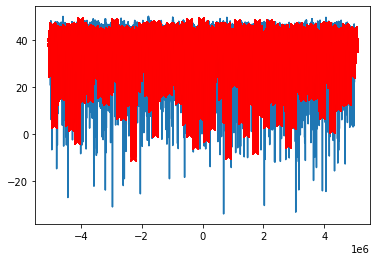

In [3]:
# form the original fft
to = time.time()
symsFFT = np.fft.fft(syms)
print("Took %f s for long fft." % (time.time()-to))

# form the bursty fft 
tb = time.time()
burstyFFT = burstFFT(syms, np.arange(0, len(syms), fs), fs)
print("Took %f s for bursty fft." % (time.time()-tb))

plt.figure()
plt.plot(makeFreq(len(symsFFT), fs), 20*np.log10(np.abs(symsFFT)))
plt.plot(makeFreq(len(burstyFFT), fs), 20*np.log10(np.abs(burstyFFT)), 'rx')

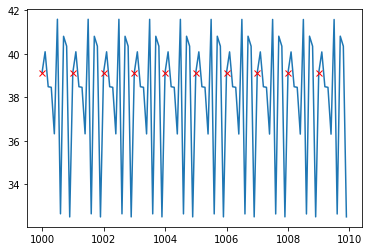

In [4]:
plt.figure()
plt.plot(makeFreq(len(symsFFT), fs)[10000:10000+100], 20*np.log10(np.abs(symsFFT))[10000:10000+100])
plt.plot(makeFreq(len(burstyFFT), fs)[1000:1000+10], 20*np.log10(np.abs(burstyFFT))[1000:1000+10], 'rx')

In [5]:
npt.assert_allclose(symsFFT[::reps], burstyFFT, rtol=1e-4)

In [6]:
ii = np.argmax(np.abs(symsFFT[::reps] - burstyFFT))
print(symsFFT[::reps][ii])
print(burstyFFT[ii])

(48.839337097311876+35.96359085092846j)
(48.83933633134383+35.963599898327836j)
